# 训练模型

当目前为止，不同的机器学习模型，也就是算法问题，更应该注重的是算法怎么训练！！！

例如，sklearn 里面好多的训练算法都是一个黑匣子，可以一无所知就实现算法的训练

很好的理解算法时如何训练的是很有必要的，而且是有帮助的
- 有助于快速定位到合适的模型
- 有助于快速定于到正确的训练算法
- 有助于快速定位到一套合适的超参数
- 有助于后期更高效地执行错误调试和错误分析

线性回归模型的两种不同的训练模型方法
- 通过 “ 闭式 ” 方程 —— 直接计算出最合适训练集的模型参数（损失函数最小化）
- 使用迭代优化方法，即梯度下降（GD），逐渐调整模型参数直至训练集上的成本函数调制最低，最终趋同于计算出来的模型参数
    - 批量梯度下降 Batch gradient descent, BGD
    - 小批量梯度下降 Small batch gradient descent, SBGD
    - 随机梯度下降 Stochastic gradient descent, SGD
    
多项式回归，适合非线性数据集，由于模型的参数多，因此容易造成对训练数据过拟合
- 使用学习曲线来分辨过拟合是否发生
- 正则化技巧，降低过度拟合训练数据的风险

两种常用于分类任务的模型
- Logistic 回归
- Softmax 回归


# 线性回归

![self](./image/linear1.png)
![self](./image/linear2.png)
![self](./image/linear3.png)
![self](./image/linear4.png)

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
   

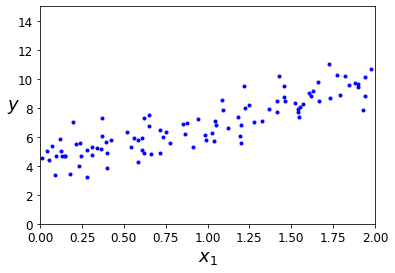

In [2]:
# 生成一些线性数据测试公式
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()


In [3]:
# 使用标准方程计算 θ 
# 使用 numpy 线性代数模块（np.linalg）中 inv() 函数对矩阵求逆，并用 dot() 方法计算矩阵内积
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[4.21509616],
       [2.77011339]])

In [4]:
# 实际期待的结果由于高斯噪声的存在，故此有所差异
# 现在使用 theta_best 进行预测
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

y_predict

array([[4.21509616],
       [9.75532293]])

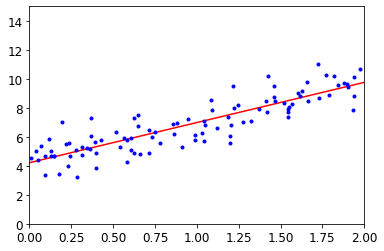

In [5]:
# 可视化模型预测结果
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

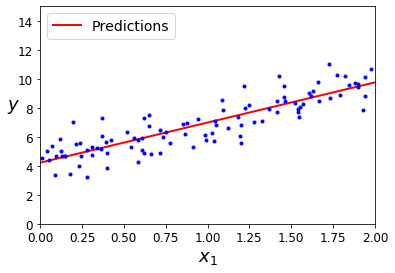

In [6]:
# 可视化调整
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
# 使用 sklearn 实现相同功能的代码如下
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [9]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

### sklearn 实现的结果 和 自己计算的结果完全一致

# 计算复杂度
- 标准方程求逆的矩阵 X.T.dot(X)，是一个 n*n 矩阵（n为特征数量）
- 这种矩阵求逆计算时间复杂度通常为 O(n^2.4) 到 O(n^3) ，具体取决于计算实现（算法导论中有解释）
- 如果将特征数量 n 翻倍，那时间复杂度将乘以大约 2^2.4=5.3 倍 到 2^3=8 倍之间
- 特征数量特别大，标准方程计算将极其缓慢，时间复杂度不佳
- 解决特征数量大，或者内存无法满足的时候，选择其他训练方法，如梯度下降


# 梯度下降
- 梯度下降时最优化理论里最基础的方法，是一种非常通用的优化算法，能够为大范围的问题寻找到最优解
- 梯度下降的中心思想就是迭代地调整参数从而是成本函数最小化
- 通过测量参数向量 θ 相关的误差函数的局部梯度，并不断沿着降低梯度的方向调整，直到梯度降为 0，达到最小值
- 具体来说，首先使用一个随机的 θ 值（随机初始化），然后逐步改进，每次踏出一步，都尝试降低成本函数（如MSE,RMSE），直到算法收敛出一个最小值
- 梯度下降最重要参数是每一步的步长，取决于超参数-学习率
- 学习率太低，算法需要经过大量迭代才能收敛，耗费时间
- 学习率太高，可能越过山谷直接到达山的另一边，甚至可能比之前起点还高，导致算法发散，值越来越大，形成震荡，无法找到解决方案
- 并不是所有的成本函数看起来都是一个漂亮的碗，有可能是像洞、山脉、高原或者其他不规则地形，导致很难收敛到最小值
- 梯度下降挑战：随机初始化，算法从左侧起步，那么会收敛到一个局部最小值，而不是全局最小值；算法从右侧起步，那么需要经过很长时间才能越过整片高原，如果停下太早，将永远达不到全局最小值
- 线性回归模型的 MSE 成本函数是一个凸函数，这意味着连接曲线上任意两个点的线段永远不会跟曲线相交，也就是只有全局最小，没有局部最小；同时也是一个连续函数，所以斜率不会产生陡峭变化
- 凸函数保证的结论：梯度下降一定获得全局最小值，只需要等待时间足够长，学习率不是太高
- 成本函数虽然是碗状的，但是如果不同特征的尺寸差距巨大，那它可能是一个非常细长的碗，碗的形状会影响梯度下降
- 应用梯度下降时，需要保证所有特征值的大小比例都差不多（standardScaler），否则收敛的时间会很长
- 训练模型就是搜素使得成本函数最小化的参数组合，这是模型参数空间层面上的搜索：模型的参数越多，这个空间的维度就越多，搜索就越难


# 批量梯度下降
# batch gradient descent


# 随机梯度下降
# stochastic gradient descent


# 小批量梯度下降
# Mini-batch gradient descent
